## . Постановка задачи

## разработать сервис для предсказания стоимости домов на основе истории предложений.

## В данные включены следующие признаки
'status' - статус продажи
'private pool’ и 'PrivatePool' - наличие частного бассейна,
'propertyType' - тип недвижимости, поместья, свойства,
'street' - адрес дома
'baths' - количество ванных комнат
'homeFacts' - сведения о строении дома, содержит несколько отдельных данных, имеющих влияние на оценку недвижимости, дома, квартиры
'fireplace' - сведения о наличии камина (ов) в доме
'city' - город
'schools' - сведения о школах в районе
'sqft' - площадь дома в футах
'zipcode' - почтовый индекс
'beds' - количество спален в доме
'state' - государство/штаты
'stories' - этажность недвижимости
'mls-id' и 'MlsId' - идентификатор MLS (Multiple Listing Service - Служба множественного листинга)
'target' - целевой признак, который необходимо спрогнозировать - цена недвижимости


### Установим необходимые библиотеки

In [1]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [3]:
! pip install --upgrade category_encoders

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pickle
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками
from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score, mean_squared_error
import joblib
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor



## Подгрузим данные

In [5]:
#import os
#os.chdir('data')

data = pd.read_csv('data.csv')
data.head()


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [6]:
print(data.shape)

(377185, 18)


## Проведем очистку данных и подготовим их к построению модели.

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [8]:
data['target'].value_counts()

target
$225,000     1462
$275,000     1355
$250,000     1312
$350,000     1296
$299,900     1276
             ... 
$390,359        1
$458,900+       1
274,359         1
$273,490+       1
$171,306        1
Name: count, Length: 43939, dtype: int64

In [9]:
df = data

In [10]:
mask = df.duplicated(subset=df.columns) # маска для фильтрации
data_duplicates = df[mask] # фильтруем наш датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')
df = df.drop_duplicates()

Число найденных дубликатов: 50


In [11]:
df.isnull().sum().sort_values(ascending=False)

private pool    372954
mls-id          352193
PrivatePool     336825
fireplace       274024
stories         150674
baths           106308
beds             91254
MlsId            66869
sqft             40550
status           39917
propertyType     34733
target            2480
city                34
street               2
zipcode              0
schools              0
state                0
homeFacts            0
dtype: int64

In [12]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

status - 11%
private pool - 99%
propertyType - 9%
street - 0%
baths - 28%
homeFacts - 0%
fireplace - 73%
city - 0%
schools - 0%
sqft - 11%
zipcode - 0%
beds - 24%
state - 0%
stories - 40%
mls-id - 93%
PrivatePool - 89%
MlsId - 18%
target - 1%


### переведем признак цены в числовой

In [13]:
def convert_currency(val):
    if val is not np.nan:
        new_val = val.replace(',', '').replace('$', '').replace('+', '').replace('/mo', '').replace('- 1437', '')
        return float(new_val)
    else:
        return np.nan

In [14]:
df['target'] = df['target'].apply(convert_currency)
df['target']

C:\Windows\Temp\ipykernel_2216\2236488249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].apply(convert_currency)


0          418000.0
1          310000.0
2         2895000.0
3         2395000.0
4            5000.0
            ...    
377180    1249000.0
377181     674999.0
377182     528000.0
377183      34500.0
377184     204900.0
Name: target, Length: 377135, dtype: float64

In [15]:
df['target'].isnull().sum()

2480

### Удалим с числом нолей более 30%

In [16]:
df_col = [col for col in df.columns if df[col].isnull().sum() > 100000]
df_col

['private pool', 'baths', 'fireplace', 'stories', 'mls-id', 'PrivatePool']

In [17]:
df.drop(df_col, axis=1, inplace=True)

C:\Windows\Temp\ipykernel_2216\1864147182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df_col, axis=1, inplace=True)


### Удалим неинформативные признаки

In [18]:
df = df.drop(columns = ['MlsId'], axis = 1)

In [19]:
df = df.drop(columns = ['zipcode'], axis = 1)

In [20]:
df.isnull().sum().sort_values(ascending=False)

beds            91254
sqft            40550
status          39917
propertyType    34733
target           2480
city               34
street              2
homeFacts           0
schools             0
state               0
dtype: int64

<Axes: >

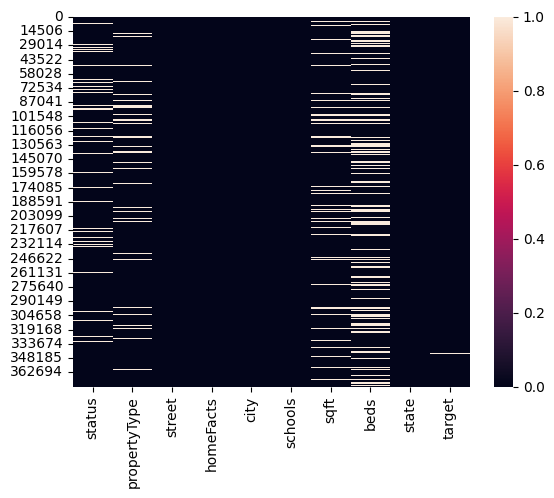

In [21]:
sns.heatmap(df.isnull()) # смотрим, какие признаки остались

In [22]:
df = df.dropna()

In [23]:
df.describe()

,target
count,2.344060e+05
mean,6.633901e+05
std,1.890223e+06
min,1.000000e+00
25%,2.149000e+05
50%,3.400000e+05
75%,5.999000e+05
max,1.950000e+08


### Сформируем новые признаки и с помощью коробки с усами посмотрим выбросы в данных. 

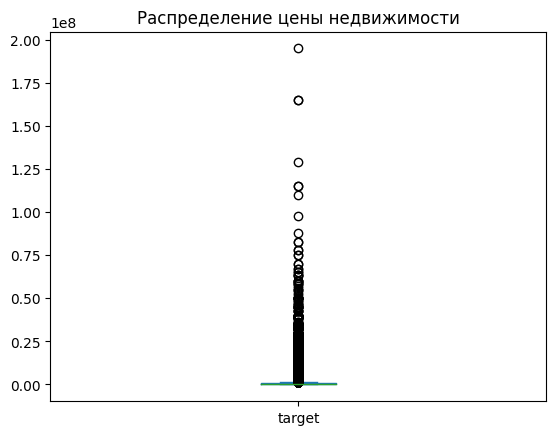

In [24]:
df['target'].plot(kind='box', title='Распределение цены недвижимости') 
plt.show()

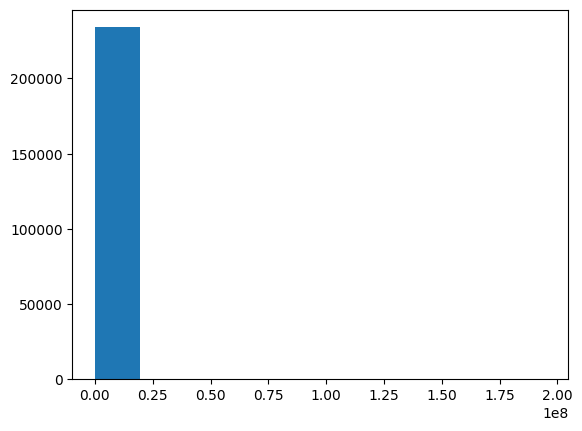

In [25]:
plt.hist(df['target'])
 
# display histogram
plt.show()

<Axes: >

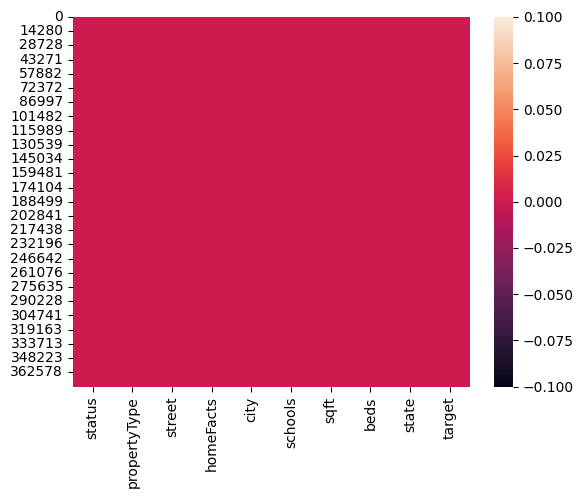

In [26]:
sns.heatmap(df.isnull())

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234406 entries, 0 to 377182
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        234406 non-null  object 
 1   propertyType  234406 non-null  object 
 2   street        234406 non-null  object 
 3   homeFacts     234406 non-null  object 
 4   city          234406 non-null  object 
 5   schools       234406 non-null  object 
 6   sqft          234406 non-null  object 
 7   beds          234406 non-null  object 
 8   state         234406 non-null  object 
 9   target        234406 non-null  float64
dtypes: float64(1), object(9)
memory usage: 19.7+ MB


In [28]:
df['schools'].head()

0    [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...
1    [{'rating': ['4/10', 'None/10', '4/10'], 'data...
2    [{'rating': ['8/10', '4/10', '8/10'], 'data': ...
3    [{'rating': ['9/10', '9/10', '10/10', '9/10'],...
5    [{'rating': [], 'data': {'Distance': [], 'Grad...
Name: schools, dtype: object

In [29]:
def process_school_ratings(data):
    
    
    # Используем регулярные выражения, чтобы найти подстроки rating
    s_rating = data['schools'].str.findall(r"\brating': ([\s\S]+?), 'data\b")
    
    # Избавимся от лишней вложенности 
    s_rating = s_rating.apply(lambda x: x[0])
    
    # Избавимся от лишних символов 
    s_rating = s_rating.replace('/10', '', regex=True)
    s_rating = s_rating.str.replace('[a-zA-Z]', '', regex=True)
    
    # Находим все цифры отдельно
    s_rating = s_rating.str.findall(r'\b([0-9])\'')
    
    # Преобразовываем в числа 
    s_rating = s_rating.apply(lambda x: [float(i) for i in x])
    
    # Находим средний рейтинг для каждой школы 
    s_rating = s_rating.apply(lambda x: np.average([int(i) for i in x]))
    
    # Создаем признак  в нашем наборе данных. Пропуски заполняем 1 
    data.loc[:, 'school_rating'] = s_rating.fillna(1).round()

# Применяем функцию к df
process_school_ratings(df)

c:\Users\LocalUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\LocalUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [30]:
df.head(2)

,status,propertyType,street,homeFacts,city,schools,sqft,beds,state,target,school_rating
0,Active,Single Family Home,240 Heather Ln,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,4,NC,418000.0,5.0
1,for sale,single-family home,12911 E Heroy Ave,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",3 Beds,WA,310000.0,4.0


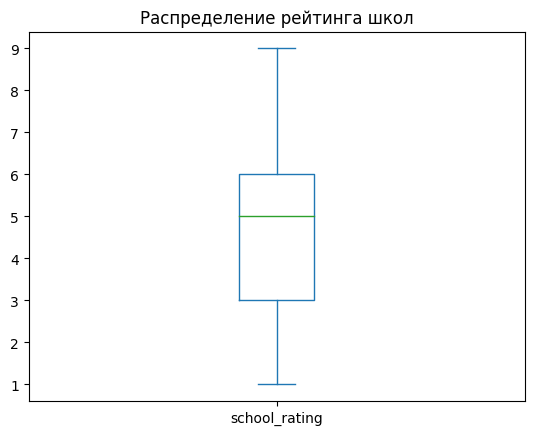

In [31]:
df['school_rating'].plot(kind='box', title='Распределение рейтинга школ') 
plt.show()

<Axes: xlabel='school_rating', ylabel='target'>

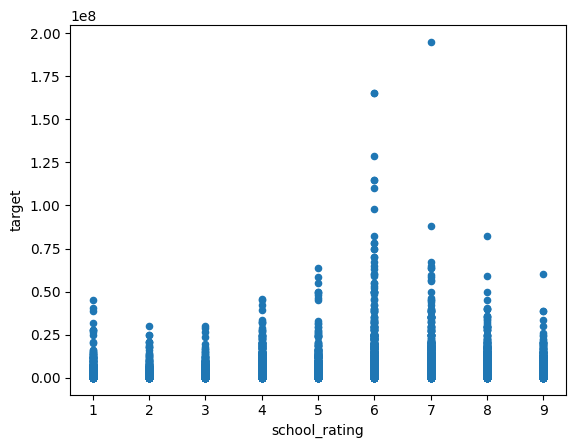

In [32]:
df.plot.scatter (x = 'school_rating', y ='target' )

In [33]:
def process_homeFacts(facts, fact_labels):
    facts = eval(facts)
    homeFacts = {}
    for item in facts['atAGlanceFacts']:
        fact_labels.add(item['factLabel'])
        homeFacts[item['factLabel']] = item['factValue']    
    
    return homeFacts
def process_homeFacts_new(facts, fact_label):
    if fact_label in facts:
        return facts[fact_label]
    
    return None

In [34]:
fact_labels = set()
    # Распарсим колонку homeFacts и запишим значения в новую колонку homeFacts_new в виде словаря {factLabel_1: factValue_1, factLabel_2: factValue_2, ...}
df['homeFacts_new'] = df['homeFacts'].apply(lambda x: process_homeFacts(x, fact_labels))
    
    # Создаем в датасете новые колонки, имена которых содержатся во множестве fact_labels
for item in fact_labels:
    df[item] = df['homeFacts_new'].apply(lambda x: process_homeFacts_new(x, item))
    # Удаляем колонки homeFacts и homeFacts_new
df.drop(['homeFacts', 'homeFacts_new'], axis=1, inplace=True)

In [35]:
df.head(3)

,status,propertyType,street,city,schools,sqft,beds,state,target,school_rating,Cooling,Remodeled year,Heating,Year built,lotsize,Price/sqft,Parking
0,Active,Single Family Home,240 Heather Ln,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,4,NC,418000.0,5.0,,,"Central A/C, Heat Pump",2019,None,$144,
1,for sale,single-family home,12911 E Heroy Ave,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",3 Beds,WA,310000.0,4.0,,,,2019,5828 sqft,$159/sqft,
2,for sale,single-family home,2005 Westridge Rd,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",3 Beds,CA,2895000.0,7.0,Central,1967,Forced Air,1961,"8,626 sqft",$965/sqft,Attached Garage


In [36]:

df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].apply(lambda x: x+' other')

lst_propertyType = ['single', 'condo', ['land', 'lot'], ['townhouse','townhome'], 'multi', 'traditional', 
    ['coop', 'co-op'], ['ranch', 'farm'], 'high rise', ['low-rise', 'low'], 'detached', 'mobile', ['contemporary','modern'],
    ['1 story', '1', 'one story'], ['2 story', '2', '2 stories', 'two stories', 'two story', 'stories'], ['3 stor', '3'], ['colonial', 'transitional', 'historical'],
    ['garden', 'cluster home'], 
    ['craft', 'cottage', 'tri-level', 'bungalow', 'cape', 'spanish', 'mediterranean', 'victorian', 'florida', 'french', 'georgian', 'loft', 'art', 'tudor'],
    ['other', 'custom', 'manufactured']]

mask_nan = df['propertyType'].isna()

for item in lst_propertyType:
    if type(item)==list:
        for ind, prprt in enumerate(item):
            df['propertyType'].where(~(df[~mask_nan].propertyType.str.contains(prprt) ), other=item[0], inplace=True)
    else:
            df['propertyType'].where(~(df[~mask_nan].propertyType.str.contains(item) ), other=item, inplace=True)

In [37]:
df = df.drop(columns = ['schools'], axis = 1)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234406 entries, 0 to 377182
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          234406 non-null  object 
 1   propertyType    234406 non-null  object 
 2   street          234406 non-null  object 
 3   city            234406 non-null  object 
 4   sqft            234406 non-null  object 
 5   beds            234406 non-null  object 
 6   state           234406 non-null  object 
 7   target          234406 non-null  float64
 8   school_rating   234406 non-null  float64
 9   Cooling         234406 non-null  object 
 10  Remodeled year  223956 non-null  object 
 11  Heating         234406 non-null  object 
 12  Year built      234403 non-null  object 
 13  lotsize         219919 non-null  object 
 14  Price/sqft      231623 non-null  object 
 15  Parking         234406 non-null  object 
dtypes: float64(2), object(14)
memory usage: 30.4+ MB


In [39]:
df.head(3)

,status,propertyType,street,city,sqft,beds,state,target,school_rating,Cooling,Remodeled year,Heating,Year built,lotsize,Price/sqft,Parking
0,Active,single,240 Heather Ln,Southern Pines,2900,4,NC,418000.0,5.0,,,"Central A/C, Heat Pump",2019,None,$144,
1,for sale,single,12911 E Heroy Ave,Spokane Valley,"1,947 sqft",3 Beds,WA,310000.0,4.0,,,,2019,5828 sqft,$159/sqft,
2,for sale,single,2005 Westridge Rd,Los Angeles,"3,000 sqft",3 Beds,CA,2895000.0,7.0,Central,1967,Forced Air,1961,"8,626 sqft",$965/sqft,Attached Garage


In [40]:
df = df.dropna()

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210581 entries, 1 to 377182
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          210581 non-null  object 
 1   propertyType    210581 non-null  object 
 2   street          210581 non-null  object 
 3   city            210581 non-null  object 
 4   sqft            210581 non-null  object 
 5   beds            210581 non-null  object 
 6   state           210581 non-null  object 
 7   target          210581 non-null  float64
 8   school_rating   210581 non-null  float64
 9   Cooling         210581 non-null  object 
 10  Remodeled year  210581 non-null  object 
 11  Heating         210581 non-null  object 
 12  Year built      210581 non-null  object 
 13  lotsize         210581 non-null  object 
 14  Price/sqft      210581 non-null  object 
 15  Parking         210581 non-null  object 
dtypes: float64(2), object(14)
memory usage: 27.3+ MB


In [42]:
def drop_if_not_4(word):
    if word in City_kist:
        return word
    else:
        return 'other'

In [43]:
City_kist = list(df['city'].value_counts().head().index)

In [44]:
df['city'] = df['city'].apply (drop_if_not_4)
df['city']

1               other
2               other
3              Dallas
5               other
8               other
             ...     
377173          other
377174    San Antonio
377175        Houston
377181          other
377182          other
Name: city, Length: 210581, dtype: object

In [45]:
df.head(3)

,status,propertyType,street,city,sqft,beds,state,target,school_rating,Cooling,Remodeled year,Heating,Year built,lotsize,Price/sqft,Parking
1,for sale,single,12911 E Heroy Ave,other,"1,947 sqft",3 Beds,WA,310000.0,4.0,,,,2019,5828 sqft,$159/sqft,
2,for sale,single,2005 Westridge Rd,other,"3,000 sqft",3 Beds,CA,2895000.0,7.0,Central,1967,Forced Air,1961,"8,626 sqft",$965/sqft,Attached Garage
3,for sale,single,4311 Livingston Ave,Dallas,"6,457 sqft",5 Beds,TX,2395000.0,9.0,Central,2006,Forced Air,2006,"8,220 sqft",$371/sqft,Detached Garage


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210581 entries, 1 to 377182
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          210581 non-null  object 
 1   propertyType    210581 non-null  object 
 2   street          210581 non-null  object 
 3   city            210581 non-null  object 
 4   sqft            210581 non-null  object 
 5   beds            210581 non-null  object 
 6   state           210581 non-null  object 
 7   target          210581 non-null  float64
 8   school_rating   210581 non-null  float64
 9   Cooling         210581 non-null  object 
 10  Remodeled year  210581 non-null  object 
 11  Heating         210581 non-null  object 
 12  Year built      210581 non-null  object 
 13  lotsize         210581 non-null  object 
 14  Price/sqft      210581 non-null  object 
 15  Parking         210581 non-null  object 
dtypes: float64(2), object(14)
memory usage: 27.3+ MB


In [47]:
ord_encoder = ce.OrdinalEncoder()
data_bin_3 = ord_encoder.fit_transform(df[['state']])

In [48]:
df[['state']]

,state
1,WA
2,CA
3,TX
5,PA
8,IA
...,...
377173,OH
377174,TX
377175,TX
377181,IL


In [49]:
data_bin_3.value_counts()

state
7        51432
3        45461
2        17189
10       13315
6        12170
17       10798
1         8708
16        8035
11        7005
13        5583
12        5003
23        4001
20        3942
4         3513
19        2691
9         2517
8         2304
22        2198
18        1006
15         868
24         682
27         589
25         513
21         400
28         209
5          191
26          75
14          73
29          57
31          30
32          12
34           5
30           3
33           3
Name: count, dtype: int64

In [50]:
df['state'] = data_bin_3
df['state']

1          1
2          2
3          3
5          4
8          5
          ..
377173    16
377174     3
377175     3
377181    13
377182     6
Name: state, Length: 210581, dtype: int32

In [51]:
df['street'].value_counts()

street
Address Not Disclosed                 430
(undisclosed Address)                 103
Address Not Available                  81
Undisclosed Address                    34
REGIONAL EXPRESS Plan in Evers Way      9
                                     ... 
3230 Potters House Way                  1
115 Timberland Loop                     1
8109 Dancing Fox St                     1
6031 Connecticut Ct                     1
15509 Linden Blvd                       1
Name: count, Length: 192494, dtype: int64

In [52]:
df = df.drop(columns = ['street'], axis = 1)

In [53]:
df['city'].value_counts()

city
other          177896
Houston         10793
San Antonio      7155
Las Vegas        5170
Miami            4905
Dallas           4662
Name: count, dtype: int64

In [54]:
df = df.drop(columns = ['city'], axis = 1)

In [55]:
# Cooling
df['Cooling'] = df['Cooling'].fillna('0') 
df['Cooling'] = df['Cooling'].apply(lambda x: 0 if x.lower() in ['','no data', 'none'] else 1)
# Heating
df['Heating'] = df['Heating'].fillna('0') 
df['Heating'] = df['Heating'].apply(lambda x: 0 if x.lower() in ['','no data', 'none'] else 1)
# Parking
df['Parking'] = df['Parking'].fillna('0')
df['Parking'] = df['Parking'].apply(lambda x: 0 if x.lower() in ['','no data', 'none'] else 1)  

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210581 entries, 1 to 377182
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          210581 non-null  object 
 1   propertyType    210581 non-null  object 
 2   sqft            210581 non-null  object 
 3   beds            210581 non-null  object 
 4   state           210581 non-null  int32  
 5   target          210581 non-null  float64
 6   school_rating   210581 non-null  float64
 7   Cooling         210581 non-null  int64  
 8   Remodeled year  210581 non-null  object 
 9   Heating         210581 non-null  int64  
 10  Year built      210581 non-null  object 
 11  lotsize         210581 non-null  object 
 12  Price/sqft      210581 non-null  object 
 13  Parking         210581 non-null  int64  
dtypes: float64(2), int32(1), int64(3), object(8)
memory usage: 23.3+ MB


In [57]:
df.head(3)

,status,propertyType,sqft,beds,state,target,school_rating,Cooling,Remodeled year,Heating,Year built,lotsize,Price/sqft,Parking
1,for sale,single,"1,947 sqft",3 Beds,1,310000.0,4.0,0,,0,2019,5828 sqft,$159/sqft,0
2,for sale,single,"3,000 sqft",3 Beds,2,2895000.0,7.0,1,1967,1,1961,"8,626 sqft",$965/sqft,1
3,for sale,single,"6,457 sqft",5 Beds,3,2395000.0,9.0,1,2006,1,2006,"8,220 sqft",$371/sqft,1


In [58]:
df['Year built'].value_counts()

Year built
2019    18884
        13008
2006     5184
2005     4886
2007     4291
        ...  
1845        1
1807        1
1740        1
1809        1
1857        1
Name: count, Length: 221, dtype: int64

In [59]:
def convert_currency_1(val):
    try:
        if val is not np.nan:
            new_val = val[0:5]
            return int(new_val)
        else:
            return np.nan
    except ValueError as e:
        return np.nan

In [60]:
df['Year built'].value_counts()

Year built
2019    18884
        13008
2006     5184
2005     4886
2007     4291
        ...  
1845        1
1807        1
1740        1
1809        1
1857        1
Name: count, Length: 221, dtype: int64

In [61]:
df1=df
df1['Year built'].fillna("").replace('', pd.NA, inplace=True)

In [62]:
df1['Year built'].value_counts()

Year built
2019    18884
        13008
2006     5184
2005     4886
2007     4291
        ...  
1845        1
1807        1
1740        1
1809        1
1857        1
Name: count, Length: 221, dtype: int64

In [63]:
df1['Year built'] = df['Year built'].apply(convert_currency_1)
df1['Year built'].value_counts()

Year built
2019.0    18884
2006.0     5184
2005.0     4886
2007.0     4291
2018.0     4288
          ...  
1809.0        1
1823.0        1
1807.0        1
1740.0        1
1857.0        1
Name: count, Length: 219, dtype: int64

In [64]:
data_bin_4 = ord_encoder.fit_transform(df1[['propertyType']])

In [65]:
data_bin_4.value_counts()

propertyType
1               149149
6                25801
2                13561
4                 7927
9                 2515
8                 2242
11                2236
3                 1414
10                1171
7                  860
14                 713
18                 653
16                 629
13                 547
5                  463
19                 234
12                 222
15                 151
17                  90
20                   3
Name: count, dtype: int64

In [66]:
df1['propertyType'] = data_bin_3
df1['propertyType']

1          1
2          2
3          3
5          4
8          5
          ..
377173    16
377174     3
377175     3
377181    13
377182     6
Name: propertyType, Length: 210581, dtype: int32

In [67]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210581 entries, 1 to 377182
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          210581 non-null  object 
 1   propertyType    210581 non-null  int32  
 2   sqft            210581 non-null  object 
 3   beds            210581 non-null  object 
 4   state           210581 non-null  int32  
 5   target          210581 non-null  float64
 6   school_rating   210581 non-null  float64
 7   Cooling         210581 non-null  int64  
 8   Remodeled year  210581 non-null  object 
 9   Heating         210581 non-null  int64  
 10  Year built      197567 non-null  float64
 11  lotsize         210581 non-null  object 
 12  Price/sqft      210581 non-null  object 
 13  Parking         210581 non-null  int64  
dtypes: float64(3), int32(2), int64(3), object(6)
memory usage: 22.5+ MB


In [68]:
df1=df

In [69]:
df1['Year built'].fillna("").replace('', pd.NA, inplace=True)

In [70]:
df1['Year built'].value_counts()

Year built
2019.0    18884
2006.0     5184
2005.0     4886
2007.0     4291
2018.0     4288
          ...  
1809.0        1
1823.0        1
1807.0        1
1740.0        1
1857.0        1
Name: count, Length: 219, dtype: int64

In [71]:
df1['Remodeled year'].fillna("").replace('', pd.NA, inplace=True)

In [72]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210581 entries, 1 to 377182
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          210581 non-null  object 
 1   propertyType    210581 non-null  int32  
 2   sqft            210581 non-null  object 
 3   beds            210581 non-null  object 
 4   state           210581 non-null  int32  
 5   target          210581 non-null  float64
 6   school_rating   210581 non-null  float64
 7   Cooling         210581 non-null  int64  
 8   Remodeled year  210581 non-null  object 
 9   Heating         210581 non-null  int64  
 10  Year built      197567 non-null  float64
 11  lotsize         210581 non-null  object 
 12  Price/sqft      210581 non-null  object 
 13  Parking         210581 non-null  int64  
dtypes: float64(3), int32(2), int64(3), object(6)
memory usage: 22.5+ MB


In [73]:
df1['Remodeled year'] = df['Remodeled year'].apply(convert_currency_1)
df1['Remodeled year'].value_counts()

Remodeled year
2006.0    3370
2005.0    3030
2007.0    2529
2004.0    2145
1980.0    2030
          ... 
1853.0       1
1888.0       1
1897.0       1
1874.0       1
1862.0       1
Name: count, Length: 147, dtype: int64

In [74]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210581 entries, 1 to 377182
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          210581 non-null  object 
 1   propertyType    210581 non-null  int32  
 2   sqft            210581 non-null  object 
 3   beds            210581 non-null  object 
 4   state           210581 non-null  int32  
 5   target          210581 non-null  float64
 6   school_rating   210581 non-null  float64
 7   Cooling         210581 non-null  int64  
 8   Remodeled year  90572 non-null   float64
 9   Heating         210581 non-null  int64  
 10  Year built      197567 non-null  float64
 11  lotsize         210581 non-null  object 
 12  Price/sqft      210581 non-null  object 
 13  Parking         210581 non-null  int64  
dtypes: float64(4), int32(2), int64(3), object(5)
memory usage: 22.5+ MB


In [75]:
# в признаке Remodeled year очень мало ненулевых данных, удалим его.
df1 = df1.drop(columns = ['Remodeled year'], axis = 1)

In [76]:
df1.isnull().sum().sort_values(ascending=False)

Year built       13014
status               0
propertyType         0
sqft                 0
beds                 0
state                0
target               0
school_rating        0
Cooling              0
Heating              0
lotsize              0
Price/sqft           0
Parking              0
dtype: int64

In [77]:

df1.dropna(subset=['Year built'], inplace=True)

In [78]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197567 entries, 1 to 377182
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         197567 non-null  object 
 1   propertyType   197567 non-null  int32  
 2   sqft           197567 non-null  object 
 3   beds           197567 non-null  object 
 4   state          197567 non-null  int32  
 5   target         197567 non-null  float64
 6   school_rating  197567 non-null  float64
 7   Cooling        197567 non-null  int64  
 8   Heating        197567 non-null  int64  
 9   Year built     197567 non-null  float64
 10  lotsize        197567 non-null  object 
 11  Price/sqft     197567 non-null  object 
 12  Parking        197567 non-null  int64  
dtypes: float64(3), int32(2), int64(3), object(5)
memory usage: 19.6+ MB


In [79]:
# Удалим неинформативные признаки
df1.drop(['status', 'sqft'], axis= 1 , inplace= True )

In [80]:
# Удалим неинформативные признаки
df1.drop(['Price/sqft', 'lotsize'], axis= 1 , inplace= True )

In [81]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197567 entries, 1 to 377182
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   propertyType   197567 non-null  int32  
 1   beds           197567 non-null  object 
 2   state          197567 non-null  int32  
 3   target         197567 non-null  float64
 4   school_rating  197567 non-null  float64
 5   Cooling        197567 non-null  int64  
 6   Heating        197567 non-null  int64  
 7   Year built     197567 non-null  float64
 8   Parking        197567 non-null  int64  
dtypes: float64(3), int32(2), int64(3), object(1)
memory usage: 13.6+ MB


In [82]:
pattern = r'(\d*\.\d+|\d+)'

In [83]:
df["beds"] = pd.to_numeric(df["beds"].str.extract(pattern)[0], downcast='float')

In [84]:
df['beds'].value_counts()

beds
3.00     82262
4.00     54692
2.00     35413
5.00     17436
6.00      5186
         ...  
0.63         1
0.32         1
1.80         1
0.71         1
88.00        1
Name: count, Length: 63, dtype: int64

In [85]:
df1['beds'] = df['beds']

In [86]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197567 entries, 1 to 377182
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   propertyType   197567 non-null  int32  
 1   beds           187473 non-null  float32
 2   state          197567 non-null  int32  
 3   target         197567 non-null  float64
 4   school_rating  197567 non-null  float64
 5   Cooling        197567 non-null  int64  
 6   Heating        197567 non-null  int64  
 7   Year built     197567 non-null  float64
 8   Parking        197567 non-null  int64  
dtypes: float32(1), float64(3), int32(2), int64(3)
memory usage: 12.8 MB


In [87]:
df1.dropna(subset=['beds'], inplace=True)

In [88]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187473 entries, 1 to 377182
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   propertyType   187473 non-null  int32  
 1   beds           187473 non-null  float32
 2   state          187473 non-null  int32  
 3   target         187473 non-null  float64
 4   school_rating  187473 non-null  float64
 5   Cooling        187473 non-null  int64  
 6   Heating        187473 non-null  int64  
 7   Year built     187473 non-null  float64
 8   Parking        187473 non-null  int64  
dtypes: float32(1), float64(3), int32(2), int64(3)
memory usage: 12.2 MB


In [89]:
df1.describe()

,propertyType,beds,state,target,school_rating,Cooling,Heating,Year built,Parking
count,187473.000000,187473.000000,187473.000000,1.874730e+05,187473.000000,187473.000000,187473.000000,187473.000000,187473.000000
mean,8.159303,3.443691,8.159303,6.606082e+05,4.875406,0.752423,0.858790,1978.102052,0.716252
std,5.856898,2.318315,5.856898,1.800245e+06,1.919243,0.431606,0.348239,34.199504,0.450817
min,1.000000,0.000000,1.000000,1.000000e+00,1.000000,0.000000,0.000000,1057.000000,0.000000
25%,3.000000,3.000000,3.000000,2.050000e+05,3.000000,1.000000,1.000000,1955.000000,0.000000
50%,7.000000,3.000000,7.000000,3.389650e+05,5.000000,1.000000,1.000000,1985.000000,1.000000
75%,11.000000,4.000000,11.000000,5.999000e+05,6.000000,1.000000,1.000000,2006.000000,1.000000
max,34.000000,708.000000,34.000000,1.650000e+08,9.000000,1.000000,1.000000,2020.000000,1.000000


# Очистка данных завершена

### Удаляем выбросы в данных

In [90]:
df2=df1

In [91]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187473 entries, 1 to 377182
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   propertyType   187473 non-null  int32  
 1   beds           187473 non-null  float32
 2   state          187473 non-null  int32  
 3   target         187473 non-null  float64
 4   school_rating  187473 non-null  float64
 5   Cooling        187473 non-null  int64  
 6   Heating        187473 non-null  int64  
 7   Year built     187473 non-null  float64
 8   Parking        187473 non-null  int64  
dtypes: float32(1), float64(3), int32(2), int64(3)
memory usage: 12.2 MB


In [92]:
df2['targetlg'] = df2['target'].apply(lambda x: np.log(x+1))
df2['bedslg'] = df2['beds'].apply(lambda x: np.log(x+1))

In [93]:
df1.drop(['target', 'beds'], axis= 1 , inplace= True )

In [94]:
df2.describe()

,propertyType,state,school_rating,Cooling,Heating,Year built,Parking,targetlg,bedslg
count,187473.000000,187473.000000,187473.000000,187473.000000,187473.000000,187473.000000,187473.000000,187473.000000,187473.000000
mean,8.159303,8.159303,4.875406,0.752423,0.858790,1978.102052,0.716252,12.768768,1.453678
std,5.856898,5.856898,1.919243,0.431606,0.348239,34.199504,0.450817,1.058086,0.262194
min,1.000000,1.000000,1.000000,0.000000,0.000000,1057.000000,0.000000,0.693147,0.000000
25%,3.000000,3.000000,3.000000,1.000000,1.000000,1955.000000,0.000000,12.230770,1.386294
50%,7.000000,7.000000,5.000000,1.000000,1.000000,1985.000000,1.000000,12.733655,1.386294
75%,11.000000,11.000000,6.000000,1.000000,1.000000,2006.000000,1.000000,13.304520,1.609438
max,34.000000,34.000000,9.000000,1.000000,1.000000,2020.000000,1.000000,18.921456,6.563856


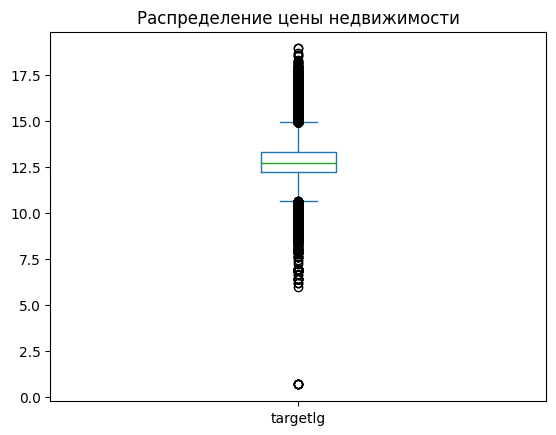

In [95]:
df2['targetlg'].plot(kind='box', title='Распределение цены недвижимости') 
plt.show()

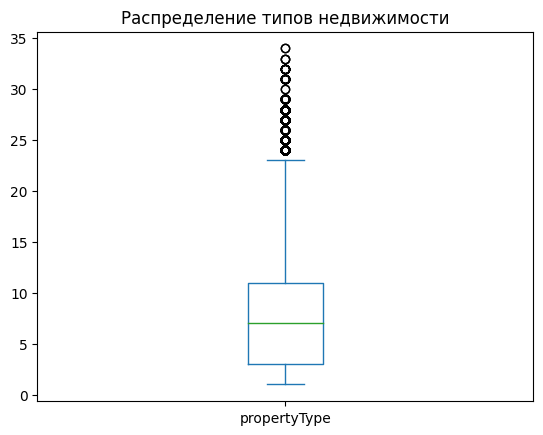

In [96]:
df2['propertyType'].plot(kind='box', title='Распределение типов недвижимости') 
plt.show()

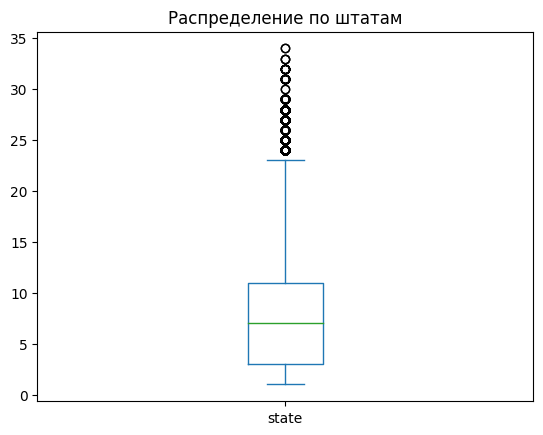

In [97]:
df2['state'].plot(kind='box', title='Распределение по штатам') 
plt.show()

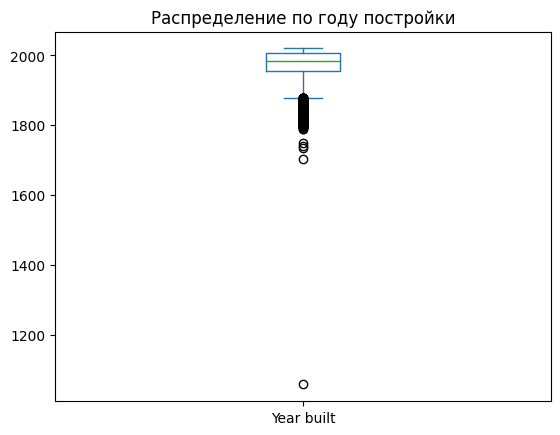

In [98]:
df2['Year built'].plot(kind='box', title='Распределение по году постройки') 
plt.show()

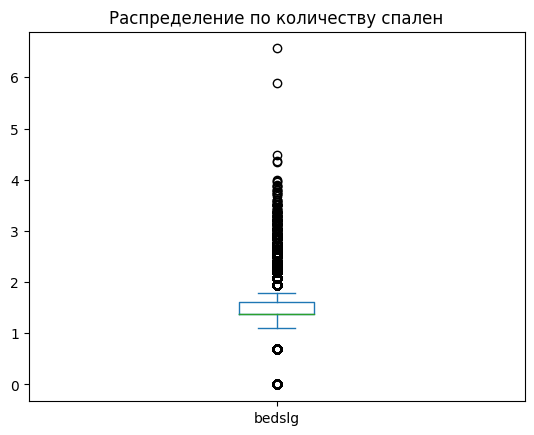

In [99]:
df2['bedslg'].plot(kind='box', title='Распределение по количеству спален') 
plt.show()

In [100]:
q_low = df2['targetlg'].quantile(0.25)
q_hi = df2['targetlg'].quantile(0.75)
q_range = q_hi - q_low
df2 = df2[(df2['targetlg'] < q_hi + 1.5 * q_range) & (df2['targetlg'] > q_low - 1.5 * q_range)]

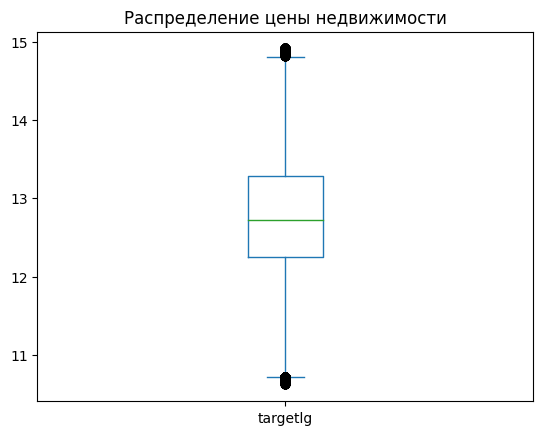

In [101]:
df2['targetlg'].plot(kind='box', title='Распределение цены недвижимости') 
plt.show()

In [102]:
q_low = df2['bedslg'].quantile(0.25)
q_hi = df2['bedslg'].quantile(0.75)
q_range = q_hi - q_low
df2 = df2[(df2['bedslg'] < q_hi + 1.5 * q_range) & (df2['bedslg'] > q_low - 1.5 * q_range)]

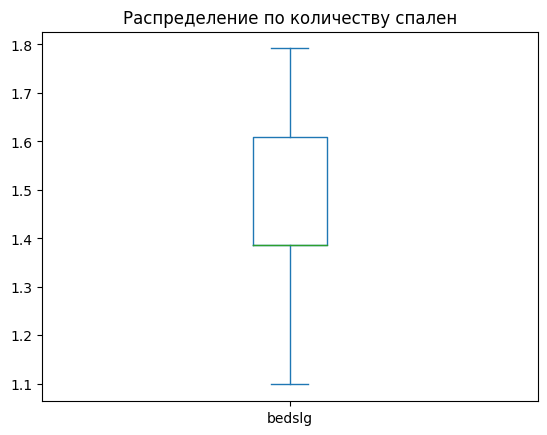

In [103]:
df2['bedslg'].plot(kind='box', title='Распределение по количеству спален') 
plt.show()

In [104]:
q_low = df2['propertyType'].quantile(0.25)
q_hi = df2['propertyType'].quantile(0.75)
q_range = q_hi - q_low
df2 = df2[(df2['propertyType'] < q_hi + 1.5 * q_range) & (df2['propertyType'] > q_low - 1.5 * q_range)]

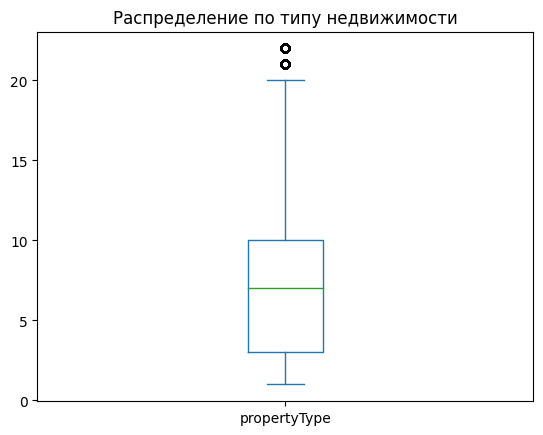

In [105]:
df2['propertyType'].plot(kind='box', title='Распределение по типу недвижимости') 
plt.show()

In [106]:
q_low = df2['Year built'].quantile(0.25)
q_hi = df2['Year built'].quantile(0.75)
q_range = q_hi - q_low
df2 = df2[(df2['Year built'] < q_hi + 1.5 * q_range) & (df2['Year built'] > q_low - 1.5 * q_range)]

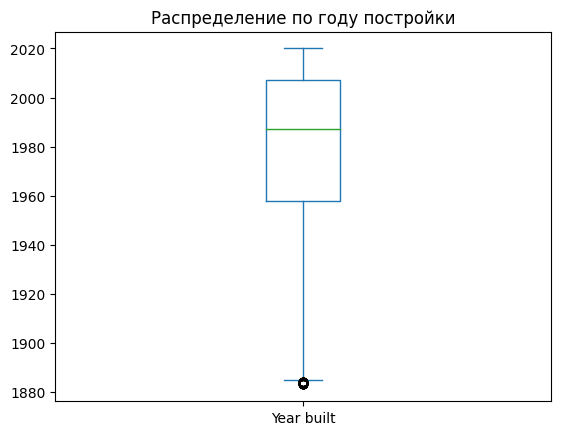

In [107]:
df2['Year built'].plot(kind='box', title='Распределение по году постройки') 
plt.show()

In [108]:
q_low = df2['state'].quantile(0.25)
q_hi = df2['state'].quantile(0.75)
q_range = q_hi - q_low
df2 = df2[(df2['state'] < q_hi + 1.5 * q_range) & (df2['state'] > q_low - 1.5 * q_range)]

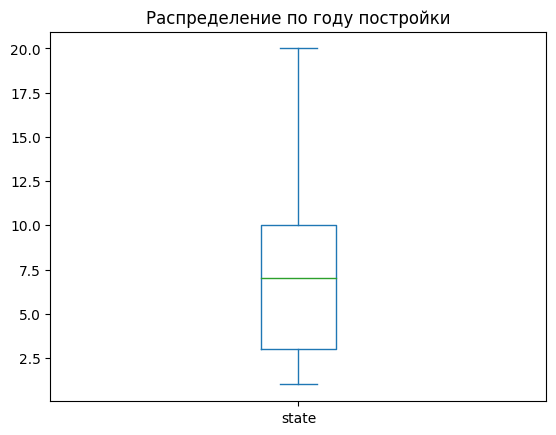

In [109]:
df2['state'].plot(kind='box', title='Распределение по году постройки') 
plt.show()

In [110]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162132 entries, 1 to 377182
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   propertyType   162132 non-null  int32  
 1   state          162132 non-null  int32  
 2   school_rating  162132 non-null  float64
 3   Cooling        162132 non-null  int64  
 4   Heating        162132 non-null  int64  
 5   Year built     162132 non-null  float64
 6   Parking        162132 non-null  int64  
 7   targetlg       162132 non-null  float64
 8   bedslg         162132 non-null  float64
dtypes: float64(4), int32(2), int64(3)
memory usage: 11.1 MB


# выбросы устранены

# Оценим возможность построения простой модели линейной корреляции

In [111]:
df2.corr()

,propertyType,state,school_rating,Cooling,Heating,Year built,Parking,targetlg,bedslg
propertyType,1.000000,1.000000,-0.129540,0.083844,0.168532,-0.107167,-0.004168,-0.213882,-0.004204
state,1.000000,1.000000,-0.129540,0.083844,0.168532,-0.107167,-0.004168,-0.213882,-0.004204
school_rating,-0.129540,-0.129540,1.000000,0.038085,-0.056855,0.266067,0.112583,0.326049,0.149672
Cooling,0.083844,0.083844,0.038085,1.000000,0.446305,0.178485,0.241928,0.007383,0.022046
Heating,0.168532,0.168532,-0.056855,0.446305,1.000000,-0.035163,0.294330,-0.102114,0.007270
Year built,-0.107167,-0.107167,0.266067,0.178485,-0.035163,1.000000,0.055445,0.130719,0.095835
Parking,-0.004168,-0.004168,0.112583,0.241928,0.294330,0.055445,1.000000,0.136466,0.111878
targetlg,-0.213882,-0.213882,0.326049,0.007383,-0.102114,0.130719,0.136466,1.000000,0.270343
bedslg,-0.004204,-0.004204,0.149672,0.022046,0.007270,0.095835,0.111878,0.270343,1.000000


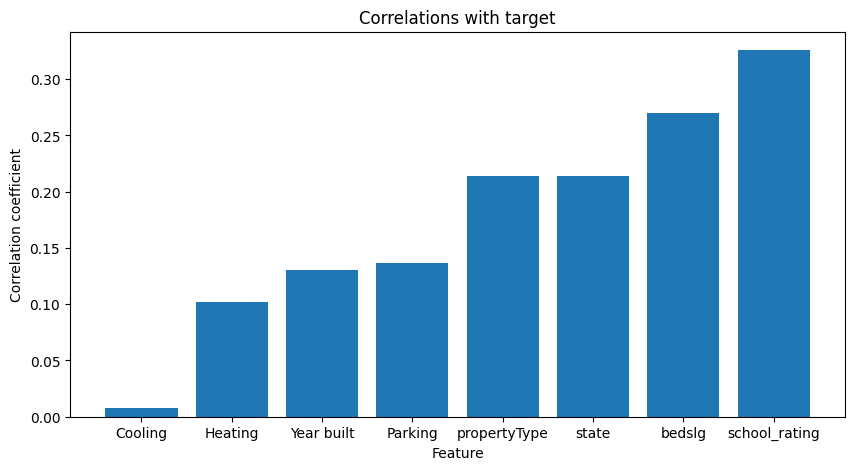

In [112]:
#Вычисляем модуль корреляции
corr_with_target = df2.corr()['targetlg'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('targetlg')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

In [113]:
X = df2.drop(['targetlg'], axis=1)
y = df2['targetlg']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [115]:

# создадим объект линейной регрессии и запишем в переменную model
model = LinearRegression()
 
# обучим нашу модель
model.fit(X_train, y_train)

LinearRegression()

In [116]:
# на основе нескольких независимых переменных (Х) предскажем цену на жилье (y)
y_pred = model.predict(X_test)
 
# выведем первые пять значений с помощью диапазона индексов
print(y_pred[:5])

[12.53874226 13.00134193 12.4274415  12.9697482  12.43792325]


In [117]:
# выведем корень среднеквадратической ошибки
# сравним тестовые и прогнозные значения цен на жилье
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))



Root Mean Squared Error (RMSE): 0.7008278320409915
R2: 0.2


In [118]:
print('w0: {}'.format(model.intercept_)) #свободный член w0
print('w1: {}'.format(model.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: 10.61345637842869
w1: [-2.50074019e+09  2.50074019e+09  1.03526801e-01  4.09758408e-02
 -2.33304136e-01  3.24249268e-04  1.86650838e-01  8.41739494e-01]


In [119]:
#Составляем список факторов (исключили целевой столбец)
features = df2.drop('targetlg', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = df2[features]
y = df2['targetlg']
#Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full.fit(X, y)

LinearRegression()

In [120]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full .coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,propertyType,3.732108e+08
1,state,-3.732108e+08
2,school_rating,1.034417e-01
3,Cooling,4.737699e-02
4,Heating,-2.380770e-01
5,Year built,2.814233e-04
6,Parking,1.879703e-01
7,bedslg,8.361576e-01
8,INTERCEPT,1.070797e+01


c:\Users\LocalUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


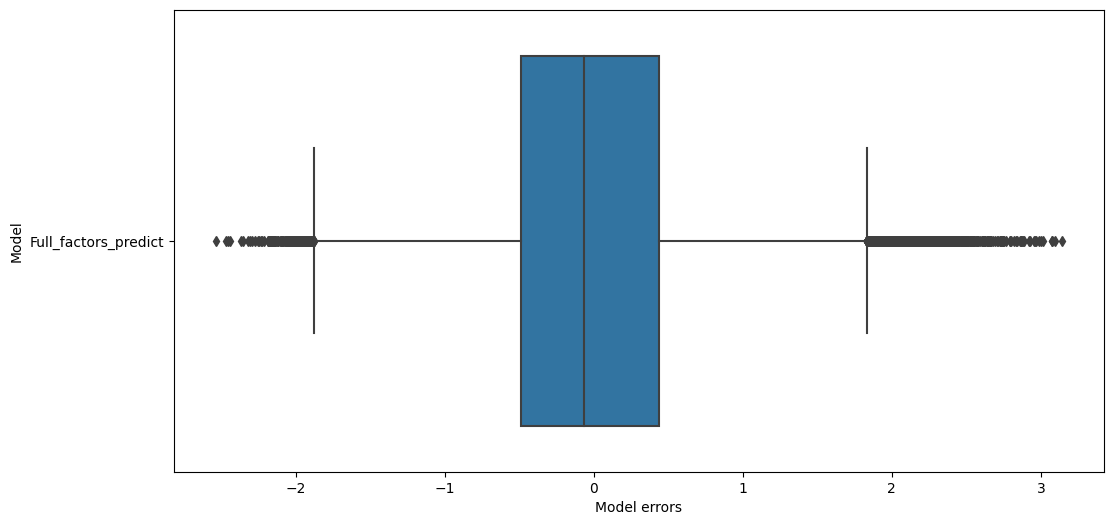

In [121]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость

#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(df2[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'Full_factors_predict': y_errors_full
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

#На обеих диаграммах присутствуют точки, сильно выбивающиеся за пределы усов. Это наблюдения, для которых модель допустила очень большую ошибку, по сравнению с основной группой.
Можно предположить, что это объекты, для которых гипотеза о линейной зависимости несправедлива, и линейной модели не хватает для предсказания целевой переменной для таких объектов.

In [122]:
#Делаем предсказание по всем признакам
y_predict_full = lr_full.predict(df2[features])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_full)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_full))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_full) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_full)))
 



MAE score: 0.556 thou. $
RMSE score: 0.701 thou. $
MAPE score: 4.364 %
R2 score: 0.203


#Модель имеет плохое значение R2

In [123]:
#Разделяем выборку на тренировочную и тестовую в соотношении 70/30
#Устанавливаем random_state для воспроизводимости результатов 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)
 
# Train: (354, 13) (354,)
# Test: (152, 13) (152,)

Train: (113492, 8) (113492,)
Test: (48640, 8) (48640,)


In [124]:
#Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model.fit(X_train, y_train)
 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test)
 
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))



Train R^2: 0.200
Test R^2: 0.210


In [125]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)
 


(113492, 44)
(48640, 44)


In [126]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))




Train R^2: 0.298
Test R^2: 0.310


#Метрика R2 выросла

In [127]:
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train)
#Производим стандартизацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)
#Производим стандартизацию тестовой выборки
X_test_scaled = scaler.transform(X_test)
 
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)
#Выводим результирующие размерности таблиц
 
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(113492, 44)
(48640, 44)


In [128]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.1)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.158
Test R^2: 0.163


In [129]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=10)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.298
Test R^2: 0.310


In [130]:
#Создаём список из 20 возможных значений от 0.0001 до 0.001
alpha_list = np.linspace(0.0001, 0.001, 3)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    lasso_lr_poly = linear_model.Lasso(alpha=alpha, max_iter=10000)
    #Обучаем модель
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    #Делаем предсказание для тестовой выборки
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

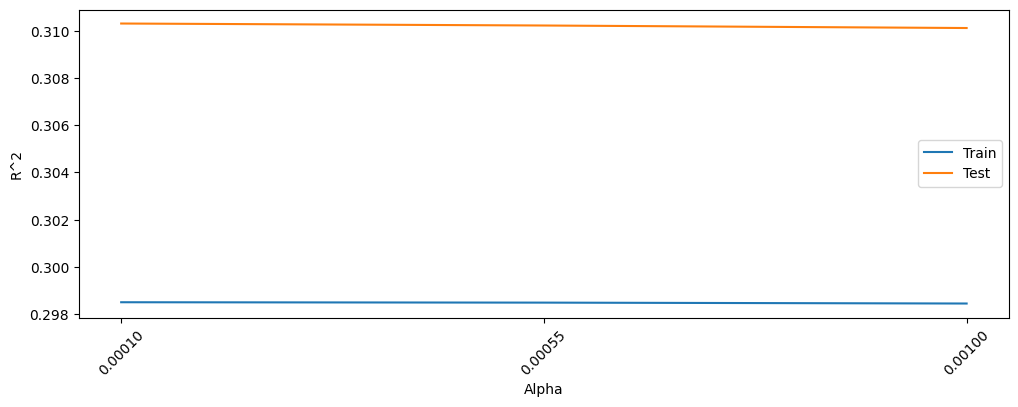

In [131]:
#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

In [132]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.0001)
#Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.298
Test R^2: 0.310


c:\Users\LocalUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e+01, tolerance: 6.973e+00
  model = cd_fast.enet_coordinate_descent(


### Простые модели показывают хорошую метрику МАРЕ, но довольно низкую R2. Попробуем модели случайного леса и сохраним  pipline

In [133]:
rf_mdel = RandomForestRegressor(n_estimators= 200,
                               n_jobs=-1,
                                bootstrap=False,
                                criterion='friedman_mse',
                                max_features=3,
                                random_state=1,
                                max_depth=55,
                                min_samples_split=5
                               )

In [134]:
rf_mdel.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_depth=55,
                      max_features=3, min_samples_split=5, n_estimators=200,
                      n_jobs=-1, random_state=1)

In [135]:
rf_prediction_train =  rf_mdel.predict(X_train)

In [136]:
rf_prediction =  rf_mdel.predict(X_test)

In [137]:
mean_absolute_percentage_error(y_train, rf_prediction_train)

0.023676286597620742

In [138]:
mean_absolute_percentage_error(y_test, rf_prediction)

0.03453934450695255

In [139]:
mean_squared_error(y_test, rf_prediction)

0.353332216641505

In [140]:
# Создаем модель дерева решений с максимальной глубиной 10
regr1 = DecisionTreeRegressor(
    max_depth=10, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Обучаем модель
regr1.fit(X_train, y_train)


 
# Создаем модель случайного леса из 10 деревьев с максимальной глубиной 10 для каждого дерева
regr2 = RandomForestRegressor(
    max_depth=10, #максимальная глубина дерева
    n_estimators=10, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)
# Обучаем модель
regr2.fit(X_train, y_train)


# Формируем предсказания каждой из моделей
y_pred1 = regr1.predict(X_test)
y_pred2 = regr2.predict(X_test)
 
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для решающего дерева {round(mean_squared_error(y_test, y_pred1), 2)}')
print(f'Качество предсказания по MSE для случайного леса  {round(mean_squared_error(y_test, y_pred2), 2)}')

Качество предсказания по MSE для решающего дерева 0.36
Качество предсказания по MSE для случайного леса  0.34


In [141]:
def rmse(y_hat, y):
    return mean_squared_error(y_hat, y, squared = False)

In [142]:
pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [143]:
y_pred = pipeline.predict(X_test)
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по метрике R2: 0.4492
Качество по RSME: 0.5857


### Удалось улучшить метрики моделей

In [144]:
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [145]:
pipeline_loaded = joblib.load('pipeline.pkl')
print(pipeline_loaded)

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])


In [146]:
pipeline.set_params(rf__n_estimators = 200)
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

In [147]:
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')

Качество по RSME: 0.585
Качество по метрике R2: 0.4504


In [148]:

estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]
 
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500,
                                          random_state=42)
)
 
pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)
print(f'Качество по RSME: {round(rmse(y_test, y_pred),2)}')
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')

Качество по RSME: 0.59
Качество по метрике R2: 0.4505


#Проведем сериализацию

In [149]:
model = pickle.dumps(pipeline_loaded )

print(type(model))
print(type(pipeline_loaded ))

<class 'bytes'>
<class 'sklearn.pipeline.Pipeline'>


In [150]:
### Проведен анализ, очистка и преобразование данных. Получены хорошие метрики модели. Модель сохранена в пайплайне.